In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gzip
import json
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from collections import Counter, defaultdict
from typing import List, Tuple, Dict
from mlxtend.frequent_patterns import fpgrowth, apriori
from mlxtend.preprocessing import TransactionEncoder

In [2]:
# Chargement et prétraitement des données
def preprocess_data(df):
    """
    Prétraite les données pour filtrer et restructurer les colonnes nécessaires.

    Args:
        df (pd.DataFrame): Données brutes.

    Returns:
        pd.DataFrame: Données prétraitées.
    """
    # Suppression des doublons
    df = df.drop_duplicates(subset=['user', 'item'])
    return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Génération des transactions pour l'extraction de motifs
def generate_transactions(df):
    """
    Génère une liste de transactions à partir des données utilisateur-item.

    Args:
        df (pd.DataFrame): Données prétraitées.

    Returns:
        list: Liste de listes représentant les items achetés par utilisateur.
    """
    transactions = df.groupby('user')['item'].apply(list).tolist()
    print(f"Nombre total de transactions : {len(transactions)}")
    print(f"Nombre total d'items uniques : {len(set(item for sublist in transactions for item in sublist))}")
    return transactions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Extraction de motifs fréquents
def extract_frequent_patterns(transactions, min_support=0.002, max_len=None):
    """
    Extrait des motifs fréquents à l'aide de l'algorithme Apriori.

    Args:
        transactions (list): Liste des transactions.
        min_support (float): Support minimum pour un motif fréquent.
        max_len (int): Longueur maximale des motifs à considérer.

    Returns:
        pd.DataFrame: Motifs fréquents et leur support.
    """
    print(max_len)
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_tf = pd.DataFrame(te_ary, columns=te.columns_)
    print("let's go")
    frequent_patterns = apriori(df_tf, min_support=min_support, use_colnames=True, max_len=max_len)
    print(f"Nombre total de motifs fréquents trouvés : {len(frequent_patterns)}")
    frequent_patterns['length'] = frequent_patterns['itemsets'].apply(len)
    max_length_generated = frequent_patterns['length'].max()
    print(f"Longueur maximale des motifs générés : {max_length_generated}")
    length_distribution = frequent_patterns['length'].value_counts()
    print(length_distribution)
    print(frequent_patterns)
    return frequent_patterns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import numpy as np

def compute_weighted_utilities(df):
    """
    Calcule l'utilité pondérée de chaque item en combinant la moyenne des notes et un poids basé sur le nombre de votes.

    Args:
        df (pd.DataFrame): Données prétraitées avec au moins les colonnes 'item', 'rating'.

    Returns:
        pd.Series: Utilité pondérée de chaque item.
    """
    # Calculer le nombre de votes (fréquence des évaluations) pour chaque item
    vote_counts = df.groupby('item')['rating'].count()

    # Calculer la moyenne des notes pour chaque item
    avg_ratings = df.groupby('item')['rating'].mean()

    # Calculer l'utilité pondérée : Moyenne * log(1 + Nombre de votes)
    weighted_utilities = avg_ratings * np.log1p(vote_counts)

    return weighted_utilities


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def qplus(
    transactions: List[List[str]],
    item_utilities: Dict[str, float],
    min_utility: float,
    use_avg_utility: bool = False,
    max_len: int = None
) -> List[Tuple[Tuple[str], float]]:
    """
    Implémente l'algorithme QPlus pour extraire des motifs à forte utilité.

    Args:
        transactions (list): Liste des transactions (ou motifs générés).
        item_utilities (dict): Utilité de chaque item.
        min_utility (float): Seuil minimum pour considérer un motif utile.
        use_avg_utility (bool): Si True, utilise l'utilité moyenne comme seuil.
        max_len (int): Longueur maximale des motifs (None pour désactiver).

    Returns:
        List[Tuple[Tuple[str], float]]: Motifs à forte utilité triés par score d'utilité.
    """
    from collections import defaultdict

    utility_count = defaultdict(float)

    # Calculer l'utilité pour les motifs
    for transaction in transactions:
        if max_len is not None and len(transaction) > max_len:
            continue  # Ignorer les motifs trop longs
        for item in transaction:
            utility_count[item] += item_utilities.get(item, 0)

    # Calculer l'utilité moyenne si nécessaire
    avg_utility = sum(utility_count.values()) / len(utility_count) if use_avg_utility else None

    # Filtrer les motifs
    high_utility_patterns = [
        (item, utility)
        for item, utility in utility_count.items()
        if utility >= (avg_utility if use_avg_utility else min_utility)
    ]

    return sorted(high_utility_patterns, key=lambda x: -x[1])



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def extract_motifs_on_demand(min_utility, high_utility_patterns):
    """
    Extraction of high-utility patterns on demand.
    """
    # Filter by utility
    patterns = [pattern for pattern in high_utility_patterns if pattern[1] >= min_utility]

    # Results
    return patterns



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
import random
import matplotlib.pyplot as plt
import pandas as pd

# Extraction d'un échantillon
def sample_patterns(high_utility_patterns, sample_size=1000):
    return random.sample(high_utility_patterns, min(sample_size, len(high_utility_patterns)))

# Analyse statistique
def analyze_sample(patterns):
    utilities = [utility for _, utility in patterns]
    print(f"Nombre total de motifs analysés : {len(patterns)}")
    print(f"Moyenne des utilités : {pd.Series(utilities).mean():.4f}")
    print(f"Médiane des utilités : {pd.Series(utilities).median():.4f}")
    print(f"Écart-type des utilités : {pd.Series(utilities).std():.4f}")
    return utilities

# Visualisation
def plot_utilities(utilities):
    plt.hist(utilities, bins=30, alpha=0.7, color='blue')
    plt.title("Distribution des utilités des motifs")
    plt.xlabel("Utilité")
    plt.ylabel("Fréquence")
    plt.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
import os

def process_on_disk(transactions, item_utilities, min_utility, chunk_size=1000):
    """
    Simule un traitement on-disk en utilisant un fichier intermédiaire.

    Args:
        transactions (list): Liste de transactions.
        item_utilities (dict): Utilité des items.
        min_utility (float): Seuil minimal d'utilité.
        chunk_size (int): Taille du lot (batch) à traiter.

    Returns:
        list: Motifs à forte utilité.
    """
    temp_file = "temp_transactions.txt"

    # Écrire les transactions sur un fichier temporaire
    with open(temp_file, "w") as f:
        for transaction in transactions:
            f.write(",".join(transaction) + "\n")

    high_utility_patterns = []

    # Lire le fichier par lots et traiter
    with open(temp_file, "r") as f:
        while chunk := f.readlines(chunk_size):
            chunk_transactions = [line.strip().split(",") for line in chunk]
            # Appeler QPlus ou tout autre traitement sur les lots
            batch_patterns = qplus(chunk_transactions, item_utilities, min_utility)
            high_utility_patterns.extend(batch_patterns)

    os.remove(temp_file)  # Supprimer le fichier temporaire
    return high_utility_patterns


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#1. **Chargement et Prétraitement des Données**

In [10]:
# Chargement et prétraitement
df_raw = pd.read_csv('../data/df.csv')
df_cleaned = preprocess_data(df_raw)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2. Génération des Transactions

In [11]:
# Génération des transactions
transactions = generate_transactions(df_cleaned)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Nombre total de transactions : 312284
Nombre total d'items uniques : 50075


#3. Découverte de Motifs Fréquents

In [12]:
# Extraction de motifs fréquents avec contrainte de taille
frequent_patterns_with_size_constraint = extract_frequent_patterns(transactions, min_support=0.002, max_len=3)
frequent_patterns_with_size_constraint = extract_frequent_patterns(transactions, min_support=0.002, max_len=2)
# Extraction sans contrainte de taille
frequent_patterns_without_size_constraint = extract_frequent_patterns(transactions, min_support=0.002, max_len=None)

# Comparaison qualitative
print(f"Nombre de motifs (avec contrainte) : {len(frequent_patterns_with_size_constraint)}")
print(f"Nombre de motifs (sans contrainte) : {len(frequent_patterns_without_size_constraint)}")


3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


let's go
Nombre total de motifs fréquents trouvés : 123
Longueur maximale des motifs générés : 3
length
1    87
2    21
3    15
Name: count, dtype: int64
      support                              itemsets  length
0    0.003116                          (7245456313)       1
1    0.002161                          (B00008BFYG)       1
2    0.002097                          (B00083HJ44)       1
3    0.003593                          (B0009R96YK)       1
4    0.002767                          (B000FF05L4)       1
..        ...                                   ...     ...
118  0.002248  (B016UQXB26, B00N3XXXCS, B016UQXB5I)       3
119  0.002248  (B00VHX8G5A, B016UQXB26, B00PD8JOTW)       3
120  0.002251  (B00VHX8G5A, B00PD8JOTW, B016UQXB5I)       3
121  0.002248  (B016UQXB26, B00PD8JOTW, B016UQXB5I)       3
122  0.002251  (B00VHX8G5A, B016UQXB26, B016UQXB5I)       3

[123 rows x 3 columns]
2
let's go
Nombre total de motifs fréquents trouvés : 108
Longueur maximale des motifs générés : 2
len

#4. Calcul des Utilités des Items

In [13]:
# Calcul des utilités
utilities = compute_weighted_utilities(df_cleaned)
utilities.head(20)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rating
item,
0971100764,12.753908
1620878747,10.556229
7245456275,21.635049
7245456313,31.952946
B000002NUS,17.744159
B00002N6SB,9.729551
B00002N6T4,15.107381
B00002N9FI,15.613917
B00003G4JR,16.637928


# 5. Extraction de Motifs à Forte Utilité avec QPlus

In [14]:
# QPlus avec utilité moyenne et contrainte de taille
high_utility_patterns = qplus(
    transactions,
    utilities.to_dict(),
    min_utility=10,
    use_avg_utility=True,
    max_len=5
)
print(f"Top 10 motifs à forte utilité (avec contrainte de taille) : {high_utility_patterns[:10]}")
# QPlus sans contrainte de taille
high_utility_patterns_no_constraints = qplus(
    transactions,
    utilities.to_dict(),
    min_utility=10,
    use_avg_utility=True,
    max_len=None
)
print(f"Top 10 motifs à forte utilité (sans contrainte de taille) : {high_utility_patterns_no_constraints[:10]}")
# Traitement on-disk
high_utility_patterns_disk = process_on_disk(transactions, utilities.to_dict(), min_utility=10)
print(f"Top 10 motifs à forte utilité (qplus on disk) : {high_utility_patterns_disk[:10]}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 10 motifs à forte utilité (avec contrainte de taille) : [('B004X55L9I', 38026.840162442306), ('B00FA2RLX2', 36654.27208566347), ('B00BMSGU9Y', 33322.72533891208), ('B0012Q2S4W', 33286.32771516073), ('B000YBAKU0', 31260.51433045705), ('B0063R2C1E', 31212.059180020457), ('B00A6TBITM', 31125.244453604093), ('B00TQ4QKIM', 27044.382546581444), ('B00CLVQNT8', 26996.31378529519), ('B001GFFRP6', 26886.052754458)]
Top 10 motifs à forte utilité (sans contrainte de taille) : [('B00FA2RLX2', 80405.27948531859), ('B004X55L9I', 51600.45340843664), ('B0014VX2M2', 51138.02569652408), ('B00BMSGU9Y', 48674.32823727732), ('B0012Q2S4W', 48557.80224381921), ('B00B4FY8YO', 47689.5768300843), ('B00A6TBITM', 47060.17821693301), ('B004ZAIXSC', 46594.03986349434), ('B00TQ4QKIM', 46073.34854655148), ('B00CLVQNT8', 45942.70633982777)]
Top 10 motifs à forte utilité (qplus on disk) : [('B004ZAIXSC', 34.642408820441354), ('B0014VX2M2', 34.02396919263034), ('B00LR454YU', 30.994495573884596), ('B00E2217I6', 30.699

# 6. Système d'Extraction à la Demande

In [15]:
# Extraction à la demande
results = extract_motifs_on_demand(min_utility=3000, high_utility_patterns=high_utility_patterns)
print(f"Motifs extraits a la demande: {results}")


Motifs extraits a la demande: [('B004X55L9I', 38026.840162442306), ('B00FA2RLX2', 36654.27208566347), ('B00BMSGU9Y', 33322.72533891208), ('B0012Q2S4W', 33286.32771516073), ('B000YBAKU0', 31260.51433045705), ('B0063R2C1E', 31212.059180020457), ('B00A6TBITM', 31125.244453604093), ('B00TQ4QKIM', 27044.382546581444), ('B00CLVQNT8', 26996.31378529519), ('B001GFFRP6', 26886.052754458), ('B0049UXD7O', 26880.786783397023), ('B00NPLSZF8', 26540.357900098752), ('B00QR2HBRA', 25740.570818592114), ('B00KXCFRSK', 25659.744859720773), ('B00B4FY8YO', 25030.440877668654), ('B0014VX2M2', 24599.329726271484), ('7245456313', 21120.89717818622), ('B0015KG5NK', 20877.229871268242), ('B000GCRWCG', 20527.506157348387), ('B0015VHIF8', 19892.10271188127), ('B0009R96YK', 19414.96557808412), ('B00X77YTS2', 19301.68921944803), ('B004ZAIXSC', 18914.75521596107), ('B001YK4M18', 18587.622918063178), ('B00125XCNY', 18563.224050045585), ('B015IEJ0GC', 17699.24596786066), ('B001ID4ZY0', 17588.614578912773), ('B016UQXB5

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 7. Analyse Qualitative sur un Échantillon

Nombre total de motifs analysés : 1000
Moyenne des utilités : 1073.4235
Médiane des utilités : 584.2786
Écart-type des utilités : 1875.7051


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


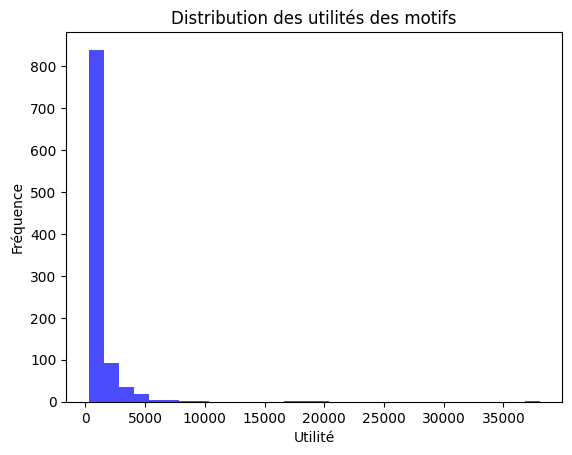

In [16]:
# Échantillonnage
sample = sample_patterns(high_utility_patterns, sample_size=1000)

# Analyse statistique
utilities_list = analyze_sample(sample)

# Visualisation
plot_utilities(utilities_list)


In [17]:
# Extraction avec contraintes de taille
frequent_patterns_with_size_constraint = qplus(
    transactions,
    utilities.to_dict(),
    min_utility=5,
    max_len=3  # Contrainte de taille (3 items max)
)

# Extraction sans contraintes de taille
frequent_patterns_without_size_constraint = qplus(
    transactions,
    utilities.to_dict(),
    min_utility=5,
    max_len=None  # Pas de contrainte
)

# Résumé des résultats
print(f"Nombre de motifs avec contrainte de taille : {len(frequent_patterns_with_size_constraint)}")
print(f"Nombre de motifs sans contrainte de taille : {len(frequent_patterns_without_size_constraint)}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Nombre de motifs avec contrainte de taille : 44081
Nombre de motifs sans contrainte de taille : 49796


In [18]:
import numpy as np
# Extraction des supports
supports_with_constraint = [pattern[1] for pattern in high_utility_patterns]
supports_without_constraint = [pattern[1] for pattern in high_utility_patterns_no_constraints]

# Moyenne et médiane
print(f"Moyenne des supports (avec contrainte) : {np.mean(supports_with_constraint):.4f}")
print(f"Médiane des supports (avec contrainte) : {np.median(supports_with_constraint):.4f}")
print(f"Moyenne des supports (sans contrainte) : {np.mean(supports_without_constraint):.4f}")
print(f"Médiane des supports (sans contrainte) : {np.median(supports_without_constraint):.4f}")


Moyenne des supports (avec contrainte) : 1175.5982
Médiane des supports (avec contrainte) : 587.2747
Moyenne des supports (sans contrainte) : 2177.3226
Médiane des supports (sans contrainte) : 1100.9351


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
import numpy as np

# Initialisation des listes pour stocker les utilités
utilities_with_constraint = []
utilities_without_constraint = []

# Extraction des utilités pour les motifs avec contrainte
for pattern in high_utility_patterns:
    if isinstance(pattern[0], tuple):  # Si le motif est un tuple d'items
        utility = sum(utilities.get(item, 0) for item in pattern[0])
    else:  # Si le motif est un seul item
        utility = utilities.get(pattern[0], 0)
    utilities_with_constraint.append(utility)

# Extraction des utilités pour les motifs sans contrainte
for pattern in high_utility_patterns_no_constraints:
    if isinstance(pattern[0], tuple):  # Si le motif est un tuple d'items
        utility = sum(utilities.get(item, 0) for item in pattern[0])
    else:  # Si le motif est un seul item
        utility = utilities.get(pattern[0], 0)
    utilities_without_constraint.append(utility)

# Calcul des moyennes et médianes
mean_utility_with_constraint = np.mean(utilities_with_constraint)
median_utility_with_constraint = np.median(utilities_with_constraint)
mean_utility_without_constraint = np.mean(utilities_without_constraint)
median_utility_without_constraint = np.median(utilities_without_constraint)

# Affichage des résultats
print(f"Moyenne des utilités (avec contrainte) : {mean_utility_with_constraint:.4f}")
print(f"Médiane des utilités (avec contrainte) : {median_utility_with_constraint:.4f}")
print(f"Moyenne des utilités (sans contrainte) : {mean_utility_without_constraint:.4f}")
print(f"Médiane des utilités (sans contrainte) : {median_utility_without_constraint:.4f}")


Moyenne des utilités (avec contrainte) : 19.0815
Médiane des utilités (avec contrainte) : 18.4434
Moyenne des utilités (sans contrainte) : 19.1803
Médiane des utilités (sans contrainte) : 18.4102


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
